# Machine Unlearning by AmnesiacML

This Notebook is adapted from [Amnesiac Machine Learning](https://ojs.aaai.org/index.php/AAAI/article/view/17371).

You are strongly advised to run this Notebook with CUDA-enabled GPU on your machine or with a GPU runtime on Colab, due to a large amount of tensor calculation.

# Imports and Setup

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
import copy
import random
import time
import pickle

torch.set_printoptions(precision=3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Entry and Processing

In [2]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,),(0.5)),
                                ])

In [3]:
# Using CIFAR100
traindata = datasets.CIFAR100('./data', download=True, train=True, transform=transform)
testdata = datasets.CIFAR100('./data', download=True, train=False, transform=transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [5]:
# Train dataloaders
target_index = []
nontarget_index = []
for i in range(0, len(traindata)):
  if traindata[i][1] == 81: # target: 81 - streetcars
    target_index.append(i)
  else:
    nontarget_index.append(i)
target_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(target_index))
nontarget_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nontarget_index))

In [6]:
# Test dataloaders
target_index = []
nontarget_index = []
for i in range(0, len(testdata)):
  if testdata[i][1] == 81:
    target_index.append(i)
  else:
    nontarget_index.append(i)
target_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(target_index))
nontarget_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nontarget_index))

In [7]:
# Unlearning dataset with all target class labels randomly assigned
unlearningdata = copy.deepcopy(traindata)
unlearninglabels = list(range(100))
unlearninglabels.remove(81)
for i in range(len(unlearningdata)):
  if unlearningdata.targets[i] == 81:
    unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(unlearningdata, batch_size=64, shuffle=True)

# Model

In [8]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 10
num_classes = 100
torch.backends.cudnn.enabled = True
criterion = F.nll_loss

In [9]:
# Training method
def train(model, epoch, loader, returnable=False):
  model.train()
  delta = {}
  for param_tensor in model.state_dict():
        if "weight" in param_tensor or "bias" in param_tensor:
            delta[param_tensor] = 0
  if returnable:
    thracc = []
    nacc = []
  for batch_idx, (data, target) in enumerate(loader):
    if torch.cuda.is_available():
      data, target = data.to(device), target.to(device)
    if 81 in target:
      before = {}
      for param_tensor in model.state_dict():
        if "weight" in param_tensor or "bias" in param_tensor:
          before[param_tensor] = model.state_dict()[param_tensor].clone()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if 81 in target:
      after = {}
      for param_tensor in model.state_dict():
        if "weight" in param_tensor or "bias" in param_tensor:
          after[param_tensor] = model.state_dict()[param_tensor].clone()
      for key in before:
        delta[key] = delta[key] + after[key] - before[key]
    if batch_idx % log_interval == 0:
      print("\rEpoch: {} [{:6d}]\tLoss: {:.6f}".format(
          epoch, batch_idx*len(data),  loss.item()
      ), end="")
    # if returnable:
    #   thracc.append(test(model, target_test_loader, dname="Streetcars only", printable=False))
    #   if batch_idx % 10 == 0:
    #     nacc.append(test(model, nontarget_test_loader, dname="Non-streetcar only", printable=False))
    #   model.train()
  if returnable:
    return thracc, nacc, delta

In [10]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
  model.eval()
  test_loss = 0
  total = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
      output = model(data)
      total += target.size()[0]
      test_loss += criterion(output, target).item()
      _, pred = torch.topk(output, 10, dim=1, largest=True, sorted=True)
      for i, t in enumerate(target):
        if t in pred[i]:
            correct += 1
  test_loss /= len(loader.dataset)
  if printable:
    print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        dname, test_loss, correct, total, 
        100. * correct / total
        ))
  return 1. * correct / total

# Original Training

In [11]:
trainingepochs = 10
forgetfulepochs = 10

accuracies = {"original": {"all": [], "target": [], "nontarget": []}, 
              "naive": {"all": [], "target": [], "nontarget": []}, 
              "unlearning": {"all": [], "target": [], "nontarget": []}, 
              "amnesiac": {"all": [], "target": [], "nontarget": []}}

In [12]:
# load resnet 18 and change to fit problem dimensionality
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet.fc = nn.Sequential(nn.Linear(512, num_classes), nn.LogSoftmax(dim=1))
if torch.cuda.is_available():
  resnet.to(device)
optimizer = optim.Adam(resnet.parameters())

In [13]:
naive_accuracy_streetcar = []
naive_accuracy_nonstreetcar = []

In [14]:
# Train new model for n epochs
batches = {}
for param_tensor in resnet.state_dict():
    if "weight" in param_tensor or "bias" in param_tensor:
        batches[param_tensor] = 0
for epoch in range(1, trainingepochs+1):
  starttime = time.process_time()
  # train(resnet, epoch, all_data_train_loader, returnable=False)
  thracc, nacc, delta = train(resnet, epoch, all_data_train_loader, returnable=True)
  naive_accuracy_streetcar += thracc
  naive_accuracy_nonstreetcar += nacc
  for key in batches:
    batches[key] = batches[key] + delta[key]
  accuracies["original"]["all"].append(test(resnet, all_data_test_loader, dname="\nAll data"))
  accuracies["original"]["target"].append(test(resnet, target_test_loader, dname="Streetcars"))
  accuracies["original"]["nontarget"].append(test(resnet, nontarget_test_loader, dname="Non-streetcars"))
  print(f"Time taken: {time.process_time() - starttime}")

Epoch: 1 [ 49920]	Loss: 3.520953
All data: Mean loss: 0.0509, Accuracy: 6551/10000 (66%)
Streetcars: Mean loss: 0.0008, Accuracy: 50/100 (50%)
Non-streetcars: Mean loss: 0.0501, Accuracy: 6501/9900 (66%)
Time taken: 50.047131952
Epoch: 2 [ 49920]	Loss: 2.615256
All data: Mean loss: 0.0428, Accuracy: 7566/10000 (76%)
Streetcars: Mean loss: 0.0004, Accuracy: 86/100 (86%)
Non-streetcars: Mean loss: 0.0423, Accuracy: 7480/9900 (76%)
Time taken: 48.510338954000005
Epoch: 3 [ 49920]	Loss: 2.164278
All data: Mean loss: 0.0375, Accuracy: 8069/10000 (81%)
Streetcars: Mean loss: 0.0004, Accuracy: 91/100 (91%)
Non-streetcars: Mean loss: 0.0370, Accuracy: 7978/9900 (81%)
Time taken: 48.24298588399999
Epoch: 4 [ 49920]	Loss: 2.101607
All data: Mean loss: 0.0361, Accuracy: 8271/10000 (83%)
Streetcars: Mean loss: 0.0002, Accuracy: 97/100 (97%)
Non-streetcars: Mean loss: 0.0358, Accuracy: 8174/9900 (83%)
Time taken: 49.278293152
Epoch: 5 [ 49920]	Loss: 1.696869
All data: Mean loss: 0.0344, Accuracy: 8

In [15]:
!mkdir -p resnet
path = F"./resnet/cifar_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [16]:
f = open(f"resnet/batches.pkl", "wb")
pickle.dump(batches, f)
f.close()

In [17]:
accuracies["naive"] = copy.deepcopy(accuracies["original"])
accuracies["unlearning"] = copy.deepcopy(accuracies["original"])
accuracies["amnesiac"] = copy.deepcopy(accuracies["original"])
del accuracies["original"]

# Naive Retraining

In [18]:
path = F"resnet/cifar_trained.pt"

In [19]:
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
if torch.cuda.is_available():
  resnet.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
naive_accuracy_streetcar = []
naive_accuracy_nonstreetcar = []

In [21]:
# Train model for 5 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonstreetcar_train_loader, returnable=False)
  thracc, nacc, _ = train(resnet, epoch, nontarget_train_loader, returnable=True)
  naive_accuracy_streetcar += thracc
  naive_accuracy_nonstreetcar += nacc
  accuracies["naive"]["all"].append(test(resnet, all_data_test_loader, dname="\nAll data"))
  accuracies["naive"]["target"].append(test(resnet, target_test_loader, dname="Streetcars"))
  accuracies["naive"]["nontarget"].append(test(resnet, nontarget_test_loader, dname="Non-streetcars"))
  path = F"resnet/cifar_retraining-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

Epoch: 11 [ 49280]	Loss: 0.504979
All data: Mean loss: 0.0457, Accuracy: 8297/10000 (83%)
Streetcars: Mean loss: 0.0014, Accuracy: 65/100 (65%)
Non-streetcars: Mean loss: 0.0445, Accuracy: 8232/9900 (83%)
Epoch: 12 [ 49280]	Loss: 0.508388
All data: Mean loss: 0.0486, Accuracy: 8321/10000 (83%)
Streetcars: Mean loss: 0.0015, Accuracy: 67/100 (67%)
Non-streetcars: Mean loss: 0.0473, Accuracy: 8254/9900 (83%)
Epoch: 13 [ 49280]	Loss: 0.294857
All data: Mean loss: 0.0513, Accuracy: 8203/10000 (82%)
Streetcars: Mean loss: 0.0017, Accuracy: 56/100 (56%)
Non-streetcars: Mean loss: 0.0499, Accuracy: 8147/9900 (82%)
Epoch: 14 [ 49280]	Loss: 0.348832
All data: Mean loss: 0.0543, Accuracy: 8132/10000 (81%)
Streetcars: Mean loss: 0.0018, Accuracy: 50/100 (50%)
Non-streetcars: Mean loss: 0.0525, Accuracy: 8082/9900 (82%)
Epoch: 15 [ 49280]	Loss: 0.341409
All data: Mean loss: 0.0563, Accuracy: 8214/10000 (82%)
Streetcars: Mean loss: 0.0019, Accuracy: 48/100 (48%)
Non-streetcars: Mean loss: 0.0548, A

# Unlearning

In [22]:
path = F"resnet/cifar_trained.pt"

In [23]:
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
if torch.cuda.is_available():
  resnet.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [24]:
unlearning_accuracy_streetcar = []
unlearning_accuracy_nonstreetcar = []

In [25]:
# Train model for 5 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, unlearning_train_loader, returnable=False)
  thracc, nacc, _ = train(resnet, epoch, unlearning_train_loader, returnable=True)
  unlearning_accuracy_streetcar += thracc
  unlearning_accuracy_nonstreetcar += nacc
  accuracies["unlearning"]["all"].append(test(resnet, all_data_test_loader, dname="\nAll data"))
  accuracies["unlearning"]["target"].append(test(resnet, target_test_loader, dname="Streetcars"))
  accuracies["unlearning"]["nontarget"].append(test(resnet, nontarget_test_loader, dname="Non-streetcars"))
  path = F"resnet/cifar_unlearning-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

Epoch: 11 [ 49920]	Loss: 0.770466
All data: Mean loss: 0.0448, Accuracy: 8260/10000 (83%)
Streetcars: Mean loss: 0.0015, Accuracy: 9/100 (9%)
Non-streetcars: Mean loss: 0.0434, Accuracy: 8251/9900 (83%)
Epoch: 12 [ 49920]	Loss: 0.373985
All data: Mean loss: 0.0484, Accuracy: 8175/10000 (82%)
Streetcars: Mean loss: 0.0016, Accuracy: 5/100 (5%)
Non-streetcars: Mean loss: 0.0471, Accuracy: 8170/9900 (83%)
Epoch: 13 [ 49920]	Loss: 0.383257
All data: Mean loss: 0.0496, Accuracy: 8156/10000 (82%)
Streetcars: Mean loss: 0.0018, Accuracy: 2/100 (2%)
Non-streetcars: Mean loss: 0.0481, Accuracy: 8154/9900 (82%)
Epoch: 14 [ 49920]	Loss: 0.362155
All data: Mean loss: 0.0538, Accuracy: 8135/10000 (81%)
Streetcars: Mean loss: 0.0021, Accuracy: 1/100 (1%)
Non-streetcars: Mean loss: 0.0520, Accuracy: 8134/9900 (82%)
Epoch: 15 [ 49920]	Loss: 0.272653
All data: Mean loss: 0.0554, Accuracy: 8140/10000 (81%)
Streetcars: Mean loss: 0.0023, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0535, Accuracy: 8


# Selective Unlearning

In [26]:
path = F"resnet/cifar_trained.pt"

In [27]:
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
if torch.cuda.is_available():
  resnet.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [28]:
selective_accuracy_streetcar = []
selective_accuracy_nonstreetcar = []

In [29]:
const = 1
with torch.no_grad():
    state = resnet.state_dict()
    for param_tensor in state:
        if "weight" in param_tensor or "bias" in param_tensor:
          state[param_tensor] = state[param_tensor] - const*batches[param_tensor]
resnet.load_state_dict(state)

<All keys matched successfully>

In [30]:
path = F"resnet/cifar_selective-epoch-{10}.pt"
torch.save({ 
        'model_state_dict': resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, path)

In [31]:
# Train model for 10 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, unlearning_train_loader, returnable=False)
  thracc, nacc, _ = train(resnet, epoch, nontarget_train_loader, returnable=True)
  selective_accuracy_streetcar += thracc
  selective_accuracy_nonstreetcar += nacc
  accuracies["amnesiac"]["all"].append(test(resnet, all_data_test_loader, dname="\nAll data"))
  accuracies["amnesiac"]["target"].append(test(resnet, target_test_loader, dname="Streetcars"))
  accuracies["amnesiac"]["nontarget"].append(test(resnet, nontarget_test_loader, dname="Non-streetcars"))
  path = F"resnet/cifar_selective-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

Epoch: 11 [ 49280]	Loss: 1.330422
All data: Mean loss: 0.0449, Accuracy: 8217/10000 (82%)
Streetcars: Mean loss: 0.0098, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0370, Accuracy: 8217/9900 (83%)
Epoch: 12 [ 49280]	Loss: 0.717953
All data: Mean loss: 0.0468, Accuracy: 8253/10000 (83%)
Streetcars: Mean loss: 0.0101, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0388, Accuracy: 8253/9900 (83%)
Epoch: 13 [ 49280]	Loss: 0.633617
All data: Mean loss: 0.0493, Accuracy: 8169/10000 (82%)
Streetcars: Mean loss: 0.0096, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0416, Accuracy: 8169/9900 (83%)
Epoch: 14 [ 49280]	Loss: 0.926418
All data: Mean loss: 0.0532, Accuracy: 8217/10000 (82%)
Streetcars: Mean loss: 0.0106, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0448, Accuracy: 8217/9900 (83%)
Epoch: 15 [ 49280]	Loss: 0.455292
All data: Mean loss: 0.0565, Accuracy: 8170/10000 (82%)
Streetcars: Mean loss: 0.0108, Accuracy: 0/100 (0%)
Non-streetcars: Mean loss: 0.0481, Accuracy: 8

Text(0, 0.5, 'Accuracy')

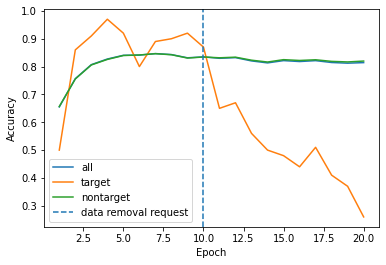

In [49]:
# Naive accuracy
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["naive"]["all"], label="all")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["naive"]["target"], label="target")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["naive"]["nontarget"], label="nontarget")
plt.axvline(x = 10, linestyle = '--', label = 'data removal request')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

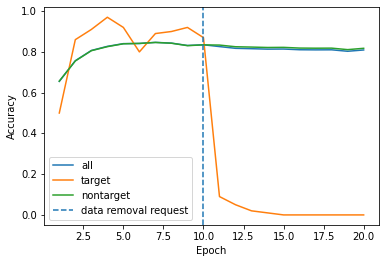

In [50]:
# Unlearning accuracy
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["unlearning"]["all"], label="all")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["unlearning"]["target"], label="target")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["unlearning"]["nontarget"], label="nontarget")
plt.axvline(x = 10, linestyle = '--', label = 'data removal request')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

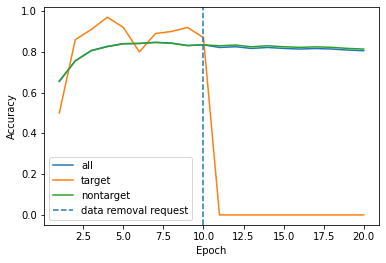

In [51]:
# Amnesiac accuracy
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["amnesiac"]["all"], label="all")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["amnesiac"]["target"], label="target")
plt.plot(range(1, trainingepochs+forgetfulepochs+1), accuracies["amnesiac"]["nontarget"], label="nontarget")
plt.axvline(x = 10, linestyle = '--', label = 'data removal request')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Reference

- Graves, L., Nagisetty, V., & Ganesh, V. (2021). Amnesiac Machine Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 35(13), 11516-11524. [[Paper](https://ojs.aaai.org/index.php/AAAI/article/view/17371)]